# 先下载股票数据

In [1]:
from mypackage.downloaddata import DlStock
import pandas as pd
import numpy as np
import datetime

In [2]:
stock_object = DlStock(stock_id='000725', start_date='2020-01-01', end_date='2021-10-25')
boe_data = stock_object.run()
boe_data.head()

downloading...: 100%|██████████| 8/8 [00:00<00:00, 840.16it/s]


,日期,开盘价,最高价,最低价,收盘价,涨跌额,涨跌幅(%),成交量(手),成交金额(万元),振幅(%),换手率(%)
0,2020-01-02,4.57,4.67,4.55,4.61,0.07,1.54,8103196,374072,2.64,2.39
1,2020-01-03,4.62,4.76,4.59,4.73,0.12,2.60,9945406,466717,3.69,2.94
2,2020-01-06,4.67,4.80,4.63,4.71,-0.02,-0.42,9472785,447133,3.59,2.80
3,2020-01-07,4.73,4.77,4.65,4.68,-0.03,-0.64,6537647,307243,2.55,1.93
4,2020-01-08,4.82,5.13,4.79,4.96,0.28,5.98,21827493,1075777,7.27,6.45


# 看看收盘价

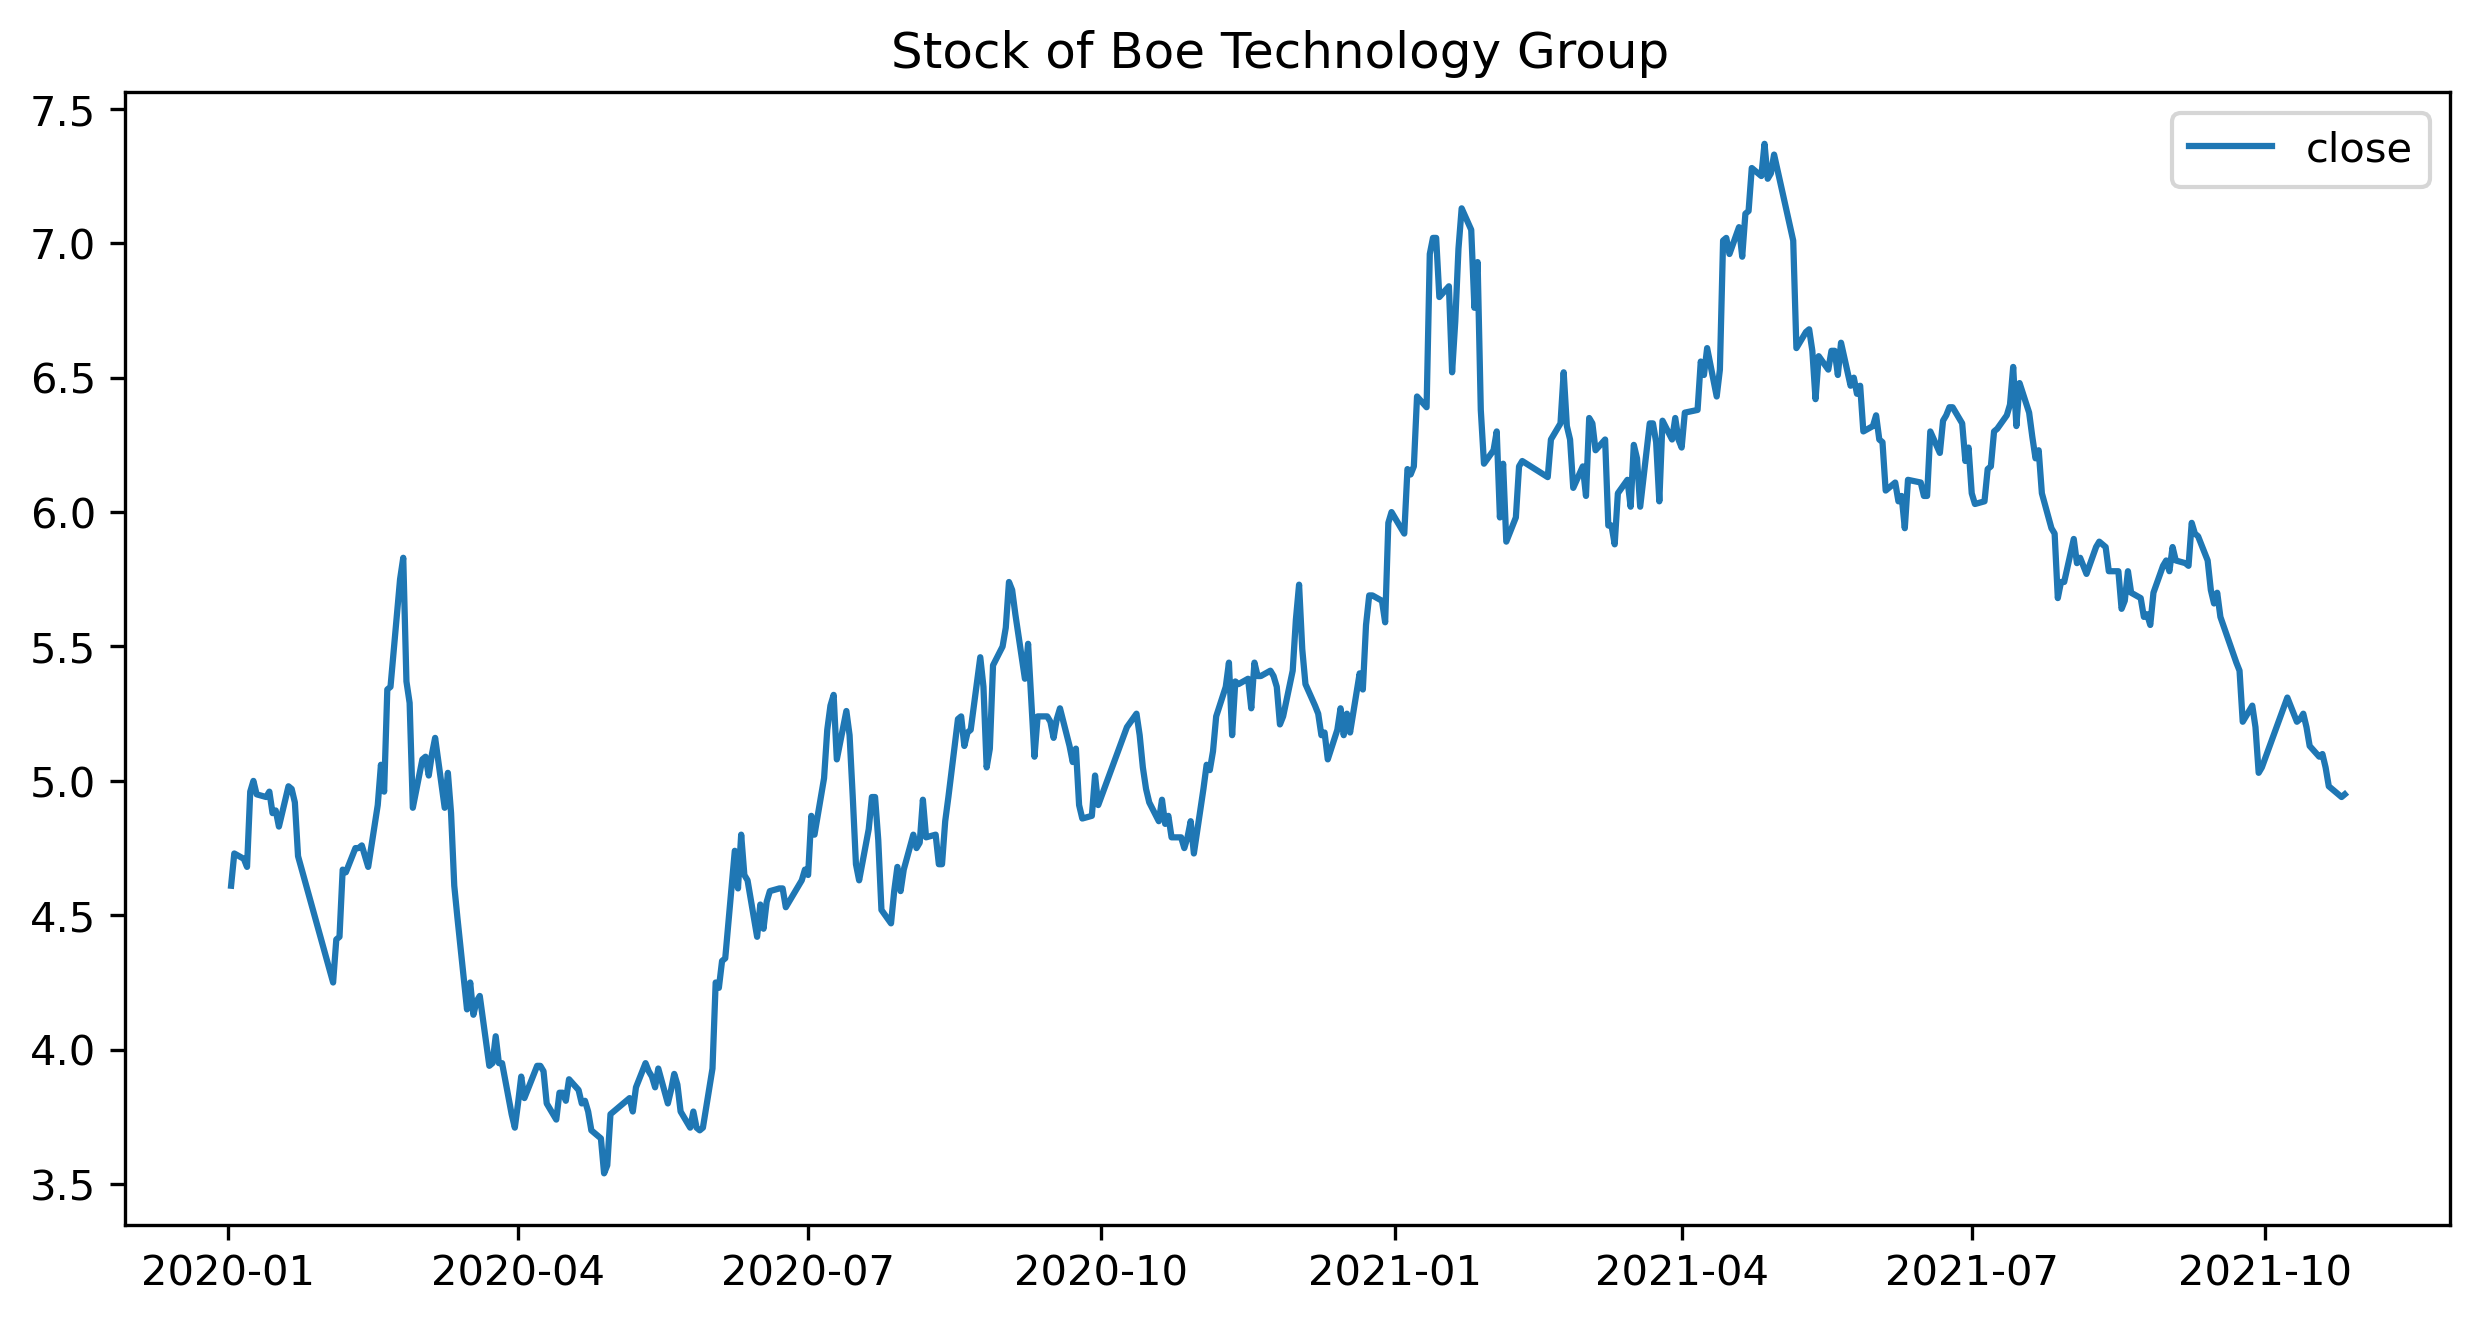

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

boe_close_data = boe_data[['收盘价', '日期']].set_index(keys=['日期'])
ax.plot(pd.to_datetime(boe_close_data.index), boe_close_data['收盘价'], label='close')
ax.set_title("Stock of Boe Technology Group ")
ax.legend()
fig.savefig("stock_boe_close.png")

# 制作训练数据
关键一步，将上面的收盘价提取出来

In [4]:
training_set = boe_close_data['收盘价'].values.reshape(-1, 1)
training_set.shape

(438, 1)

In [89]:
from sklearn.preprocessing import MinMaxScaler

from torch.autograd import Variable
import torch
import torch.nn as nn


def sliding_windows(data: np.array, seq_length: int):
    x, y = [], []

    for i in range(data.shape[0] - seq_length - 1):
        _x = data[i:(i + seq_length)]
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)


sc = MinMaxScaler()
training_set_sc = sc.fit_transform(training_set)

seq_length = 10
x, y = sliding_windows(data=training_set_sc, seq_length=seq_length)

train_size = int(y.shape[0] * 0.80)
test_size = int(y.shape[0]) - train_size

dataX = Variable(torch.Tensor(x))
dataY = Variable(torch.Tensor(y))

trainX = Variable(torch.Tensor(x[0:train_size]))
trainY = Variable(torch.Tensor(y[0:train_size]))

testX = Variable(torch.Tensor(x[train_size:]))
testY = Variable(torch.Tensor(y[train_size:]))

# 模型部分

In [90]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.seq_length = seq_length
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=True)
        self.fc = nn.Linear(in_features=self.hidden_size, out_features=self.num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

In [97]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 4
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

all_loss_list = []
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    loss = criterion(outputs, trainY)

    loss.backward()
    optimizer.step()

    all_loss_list.append(loss.item())

    if epoch % 100 == 0:
        print(f"epoch: {epoch}; loss: {loss.item()}")

epoch: 0; loss: 0.09543962776660919
epoch: 100; loss: 0.0030665562953799963
epoch: 200; loss: 0.002128144260495901
epoch: 300; loss: 0.001800067606382072
epoch: 400; loss: 0.0016685606678947806
epoch: 500; loss: 0.0016094858292490244
epoch: 600; loss: 0.0015814388170838356
epoch: 700; loss: 0.0015682546654716134
epoch: 800; loss: 0.0015622879145666957
epoch: 900; loss: 0.0015593982534483075
epoch: 1000; loss: 0.001557660405524075
epoch: 1100; loss: 0.0015563472406938672
epoch: 1200; loss: 0.0015552145196124911
epoch: 1300; loss: 0.0015541762113571167
epoch: 1400; loss: 0.0015531937824562192
epoch: 1500; loss: 0.0015522429021075368
epoch: 1600; loss: 0.0015513113467022777
epoch: 1700; loss: 0.0015503979520872235
epoch: 1800; loss: 0.0015495136613026261
epoch: 1900; loss: 0.001548680942505598


Text(0, 0.5, 'loss value')

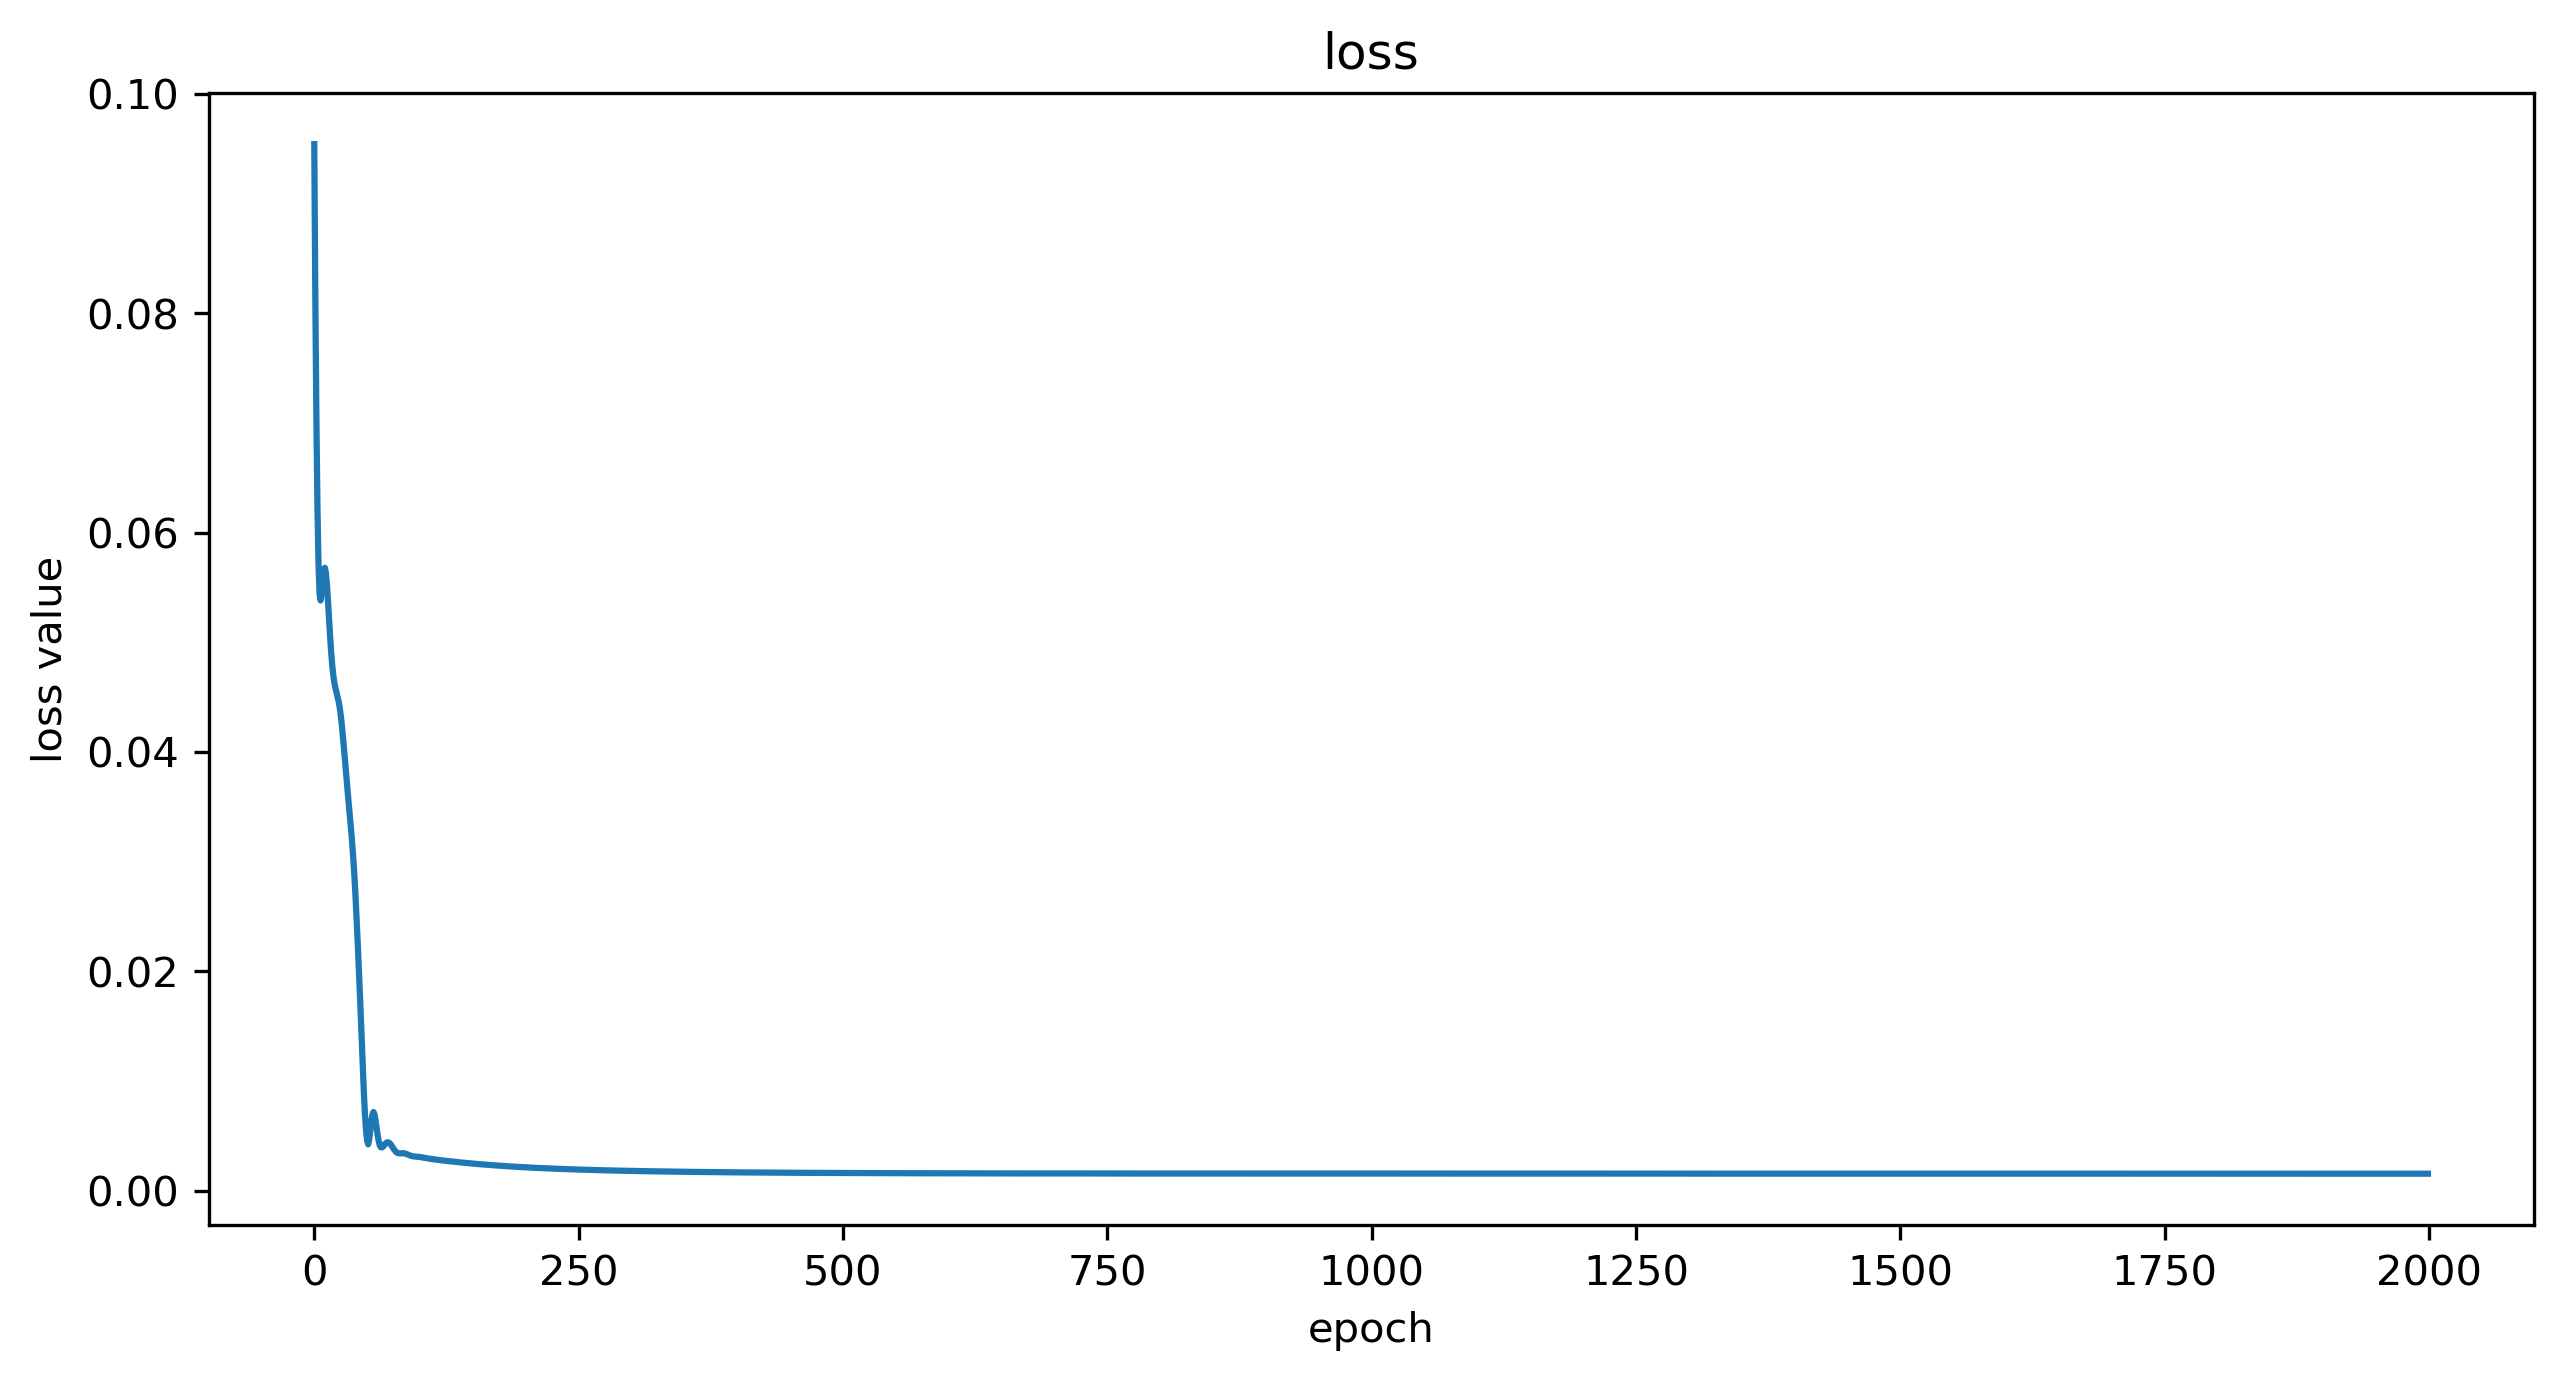

In [98]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
ax.plot(all_loss_list)
ax.set_title("loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss value")

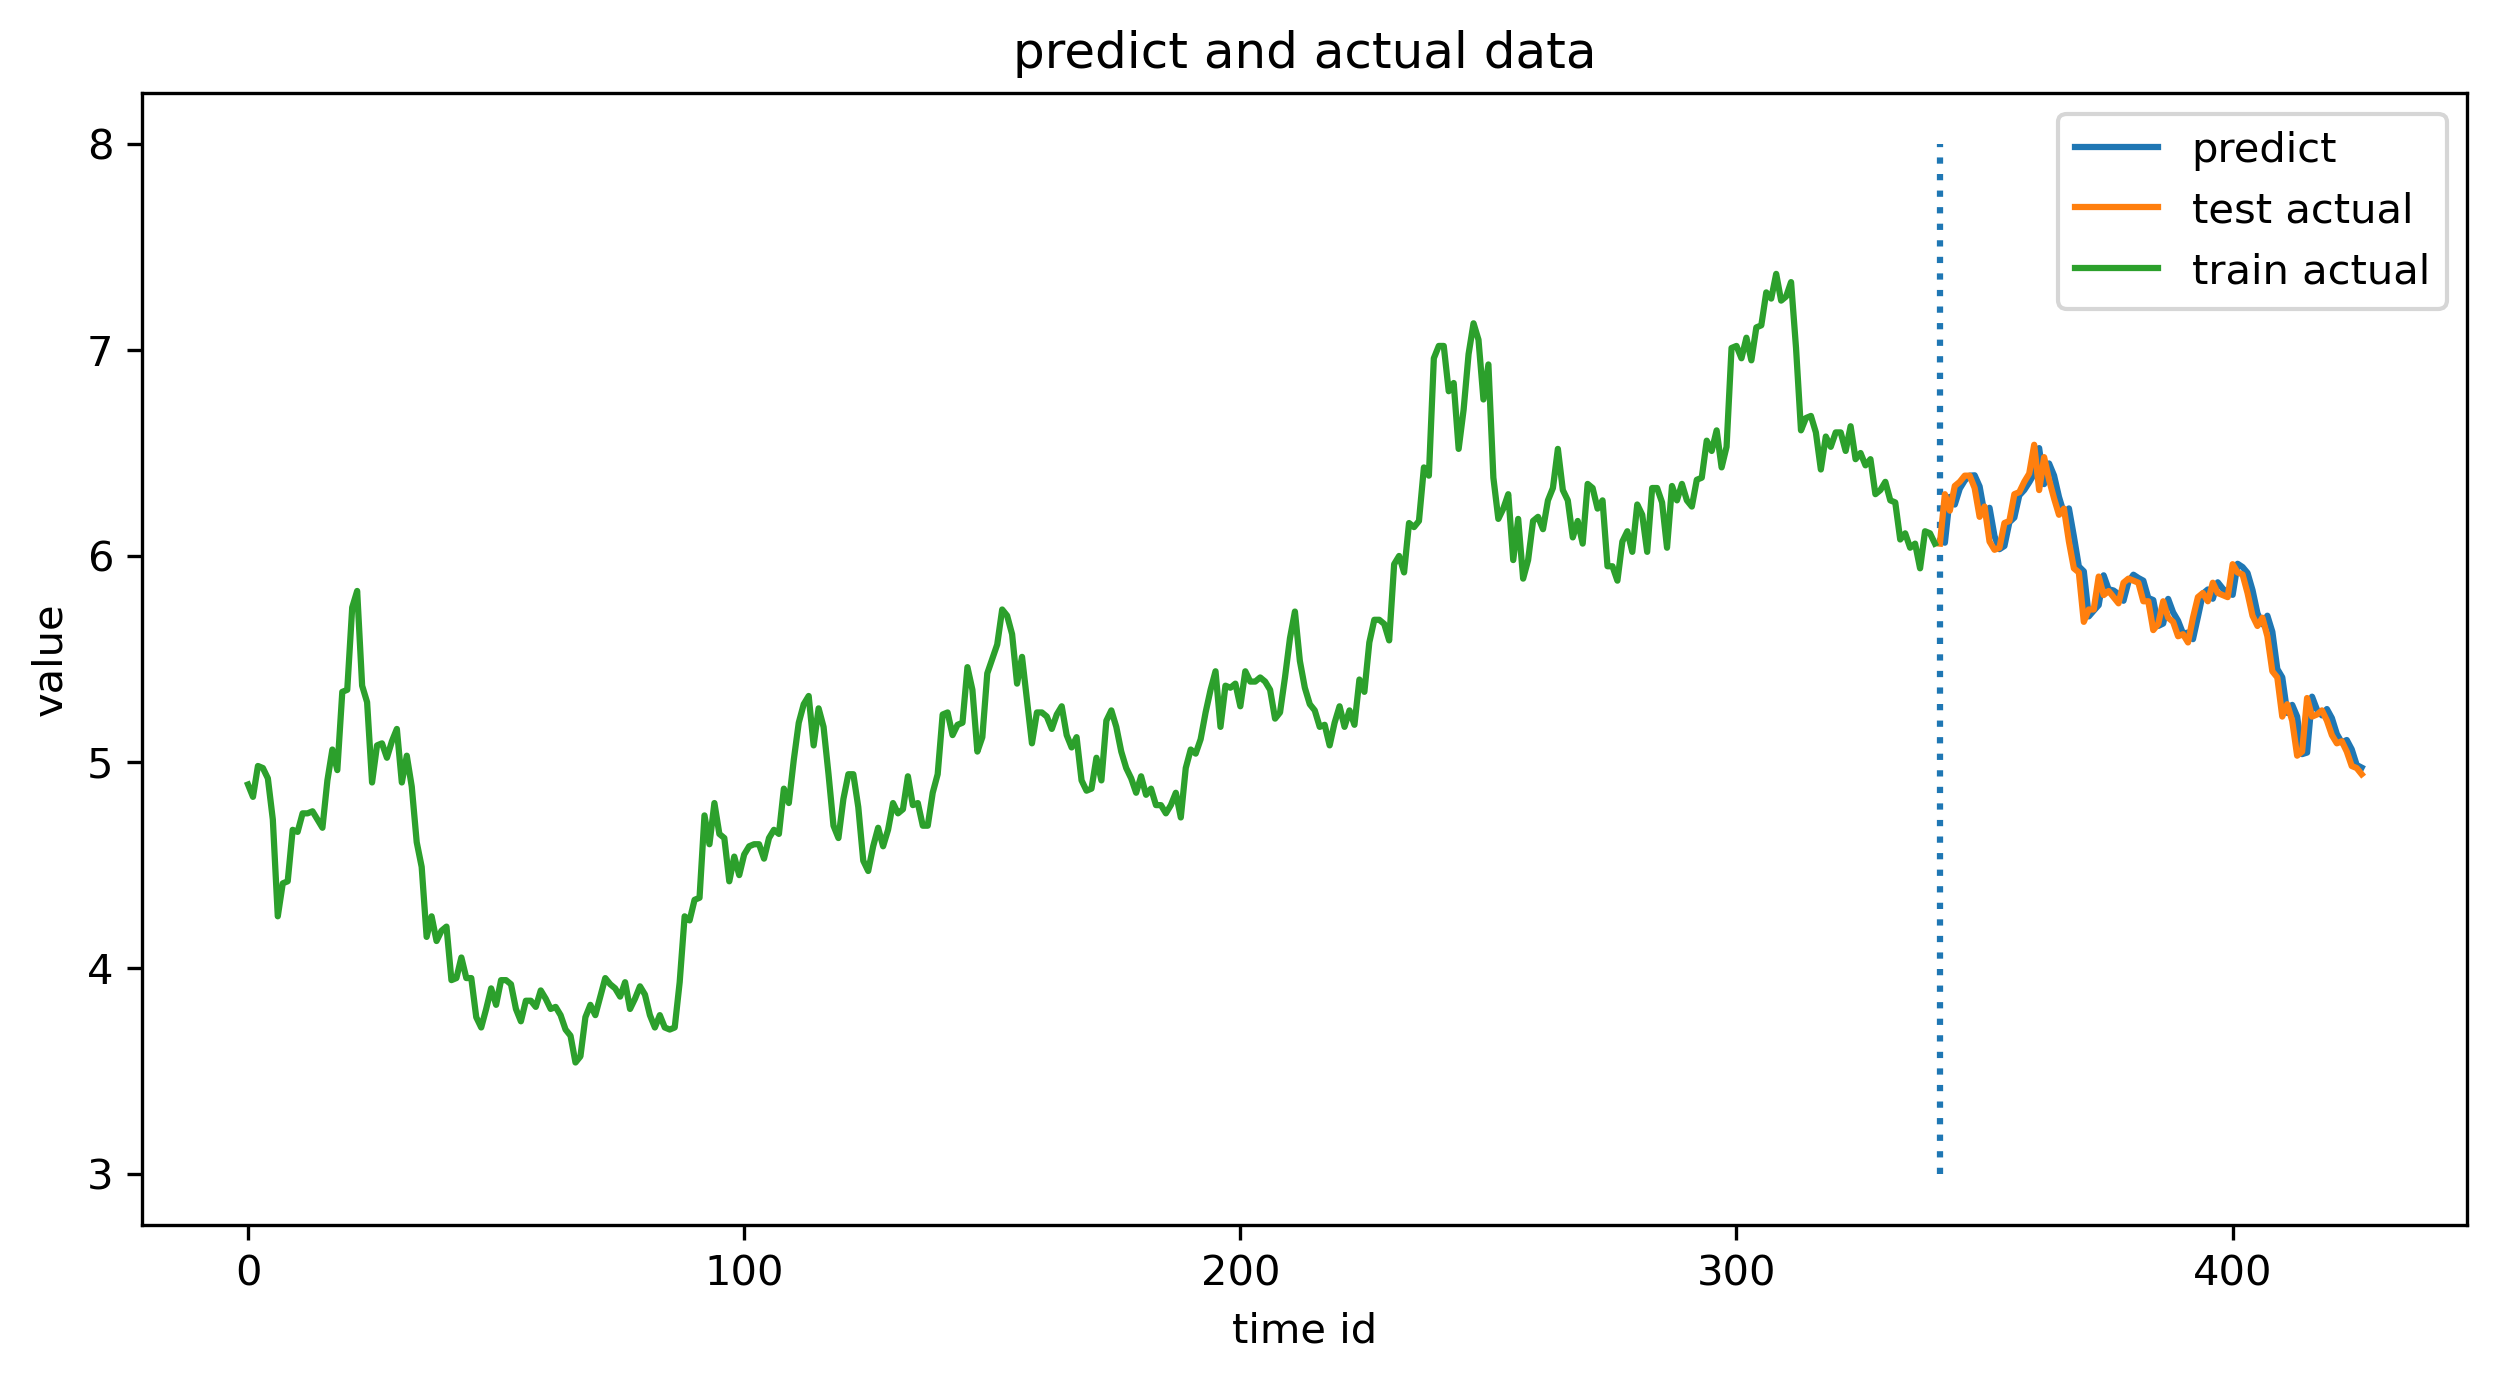

In [99]:
with torch.no_grad():
    predict_test = lstm(testX)


def data2plot(data, start_value, ax, label):
    value = sc.inverse_transform(data.numpy())
    x_value = np.arange(start=start_value, stop=start_value + value.shape[0])
    ax.plot(x_value, value, label=label)


fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
data2plot(data=predict_test, start_value=train_size, ax=ax, label="predict")
data2plot(data=testY, start_value=train_size, ax=ax, label="test actual")
data2plot(data=trainY, start_value=0, ax=ax, label="train actual")

ax.vlines(x=train_size, ymin=np.min(ax.get_yticks()), ymax=np.max(ax.get_yticks()), linestyles="dotted")
ax.set_title("predict and actual data")
ax.set_ylabel("value")
ax.set_xlabel("time id")
ax.legend()

fig.savefig("predict_actual_data.png")

# 多步预测

In [100]:
old_data_sc = training_set_sc.flatten().tolist()[0:train_size]
real_data_sc = training_set_sc.flatten().tolist()[train_size:]

predict_new_sc_list = []
predict_new_real_list = []
from itertools import chain
from tqdm import tqdm

for i in tqdm(range(test_size)):
    with torch.no_grad():
        temp_input_data = np.array(list(chain(*[old_data_sc,
                                                predict_new_sc_list]))[-seq_length:]
                                   ).reshape(1, seq_length, -1)
        temp_input_data = Variable(torch.Tensor(temp_input_data))
        temp_pred_new_sc = lstm(temp_input_data)

        predict_new_sc_list.append(
            temp_pred_new_sc.flatten().tolist()[0]
        )
        predict_new_real_list.append(
            sc.inverse_transform(temp_pred_new_sc.reshape(-1, 1)).flatten().tolist()[0]
        )


100%|██████████| 86/86 [00:00<00:00, 1841.27it/s]


(331.0, 381.0)

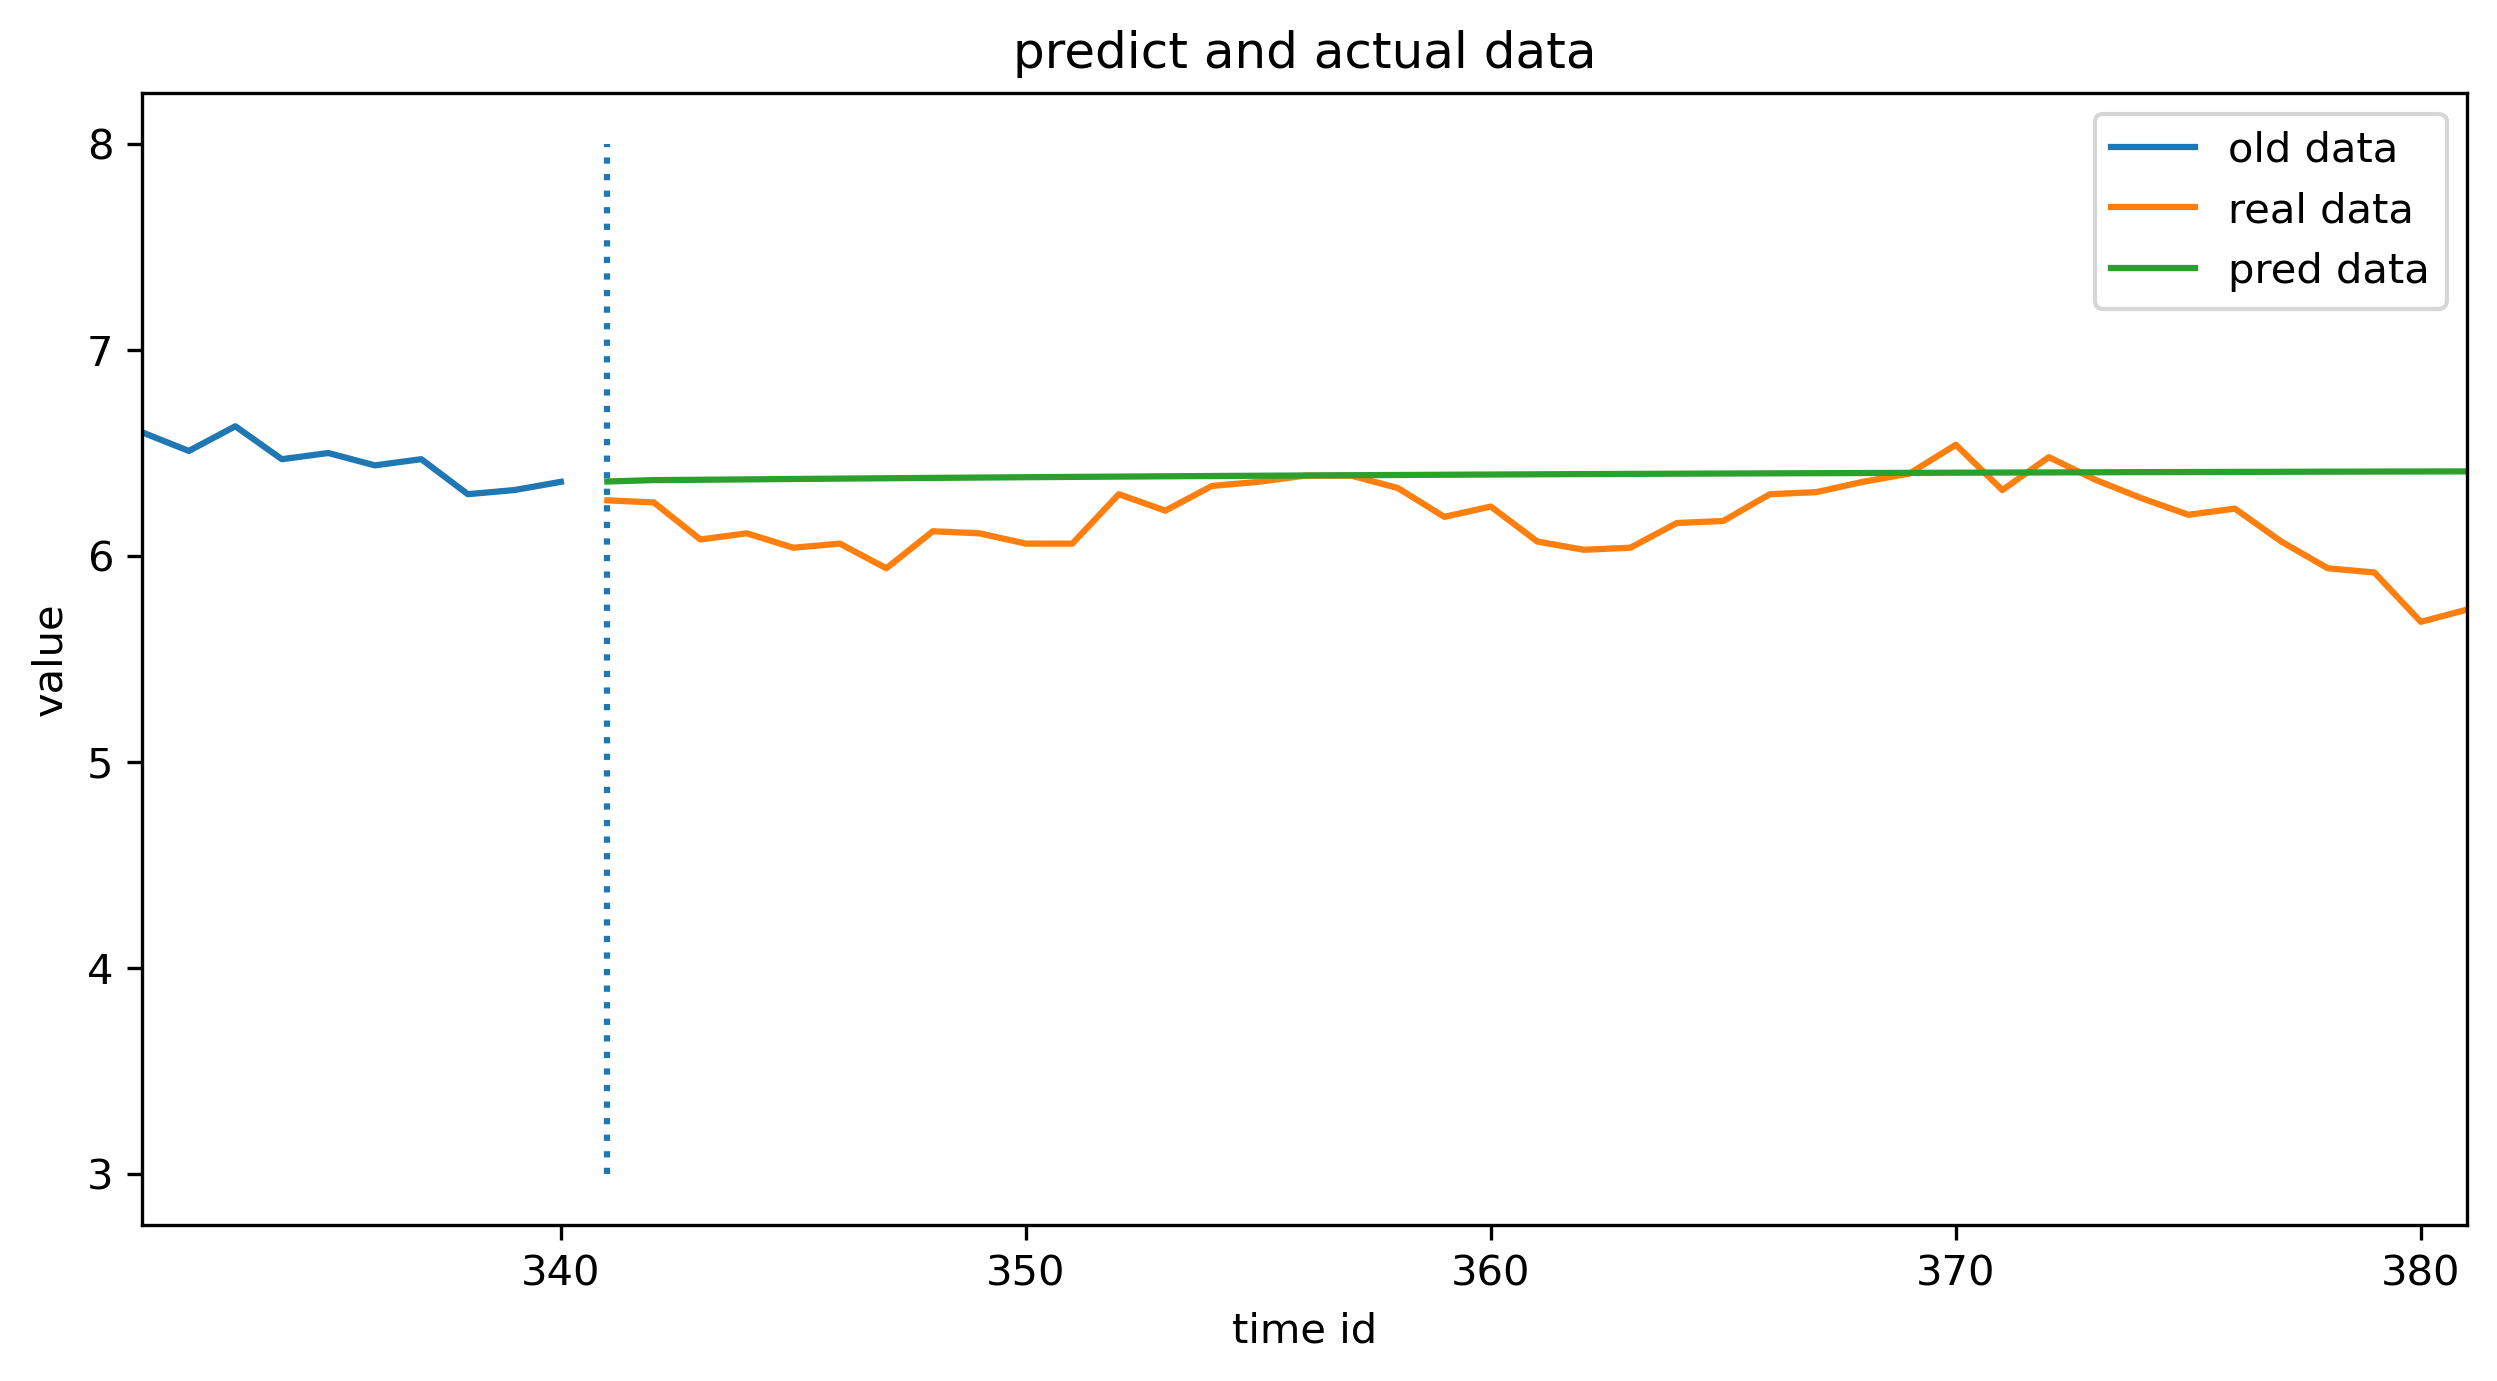

In [110]:
old_data_real = sc.inverse_transform(np.array(old_data_sc).reshape(-1, 1)).flatten().tolist()
real_data_real = sc.inverse_transform(np.array(real_data_sc).reshape(-1, 1)).flatten().tolist()


def data2plot2(data, start_value, ax, label):
    value = data
    x_value = np.arange(start=start_value, stop=start_value + len(value))
    ax.plot(x_value, value, label=label)


fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

data2plot2(data=old_data_real, start_value=0, ax=ax, label="old data")
data2plot2(data=real_data_real, start_value=train_size, ax=ax, label="real data")
data2plot2(data=predict_new_real_list, start_value=train_size, ax=ax, label='pred data')
ax.vlines(x=train_size, ymin=np.min(ax.get_yticks()), ymax=np.max(ax.get_yticks()), linestyles="dotted")
ax.set_title("predict and actual data")
ax.set_ylabel("value")
ax.set_xlabel("time id")
ax.legend()
ax.set_xlim([train_size-10,train_size+40])


